# Effect of norm bounds on the solution

In this jupyter notebook we will see what happens to the property bounds when we choose different prior norm bounds.

In [9]:
from sola.main_classes import domains
from sola.main_classes import spaces
from sola.aux import normal_data
from sola.main_classes import functions
from sola.main_classes import mappings
from sola.main_classes.SOLA_DLI import  Problem
from sola.aux.other import round_to_sf

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines

# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

Just like with all other cases, we start by defining the spaces and mappings involved.

In [10]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['m_1', 'm_2', 'm_3']
physical_parameters_symbols = {'m_1': '$m^1$', 'm_2': '$m^2$', 'm_3': '$m^3$'}
# Edit region -------------

no_of_params = len(physical_parameters)
domain = domains.HyperParalelipiped(bounds=[[0, 1]])
constituent_models_spaces = [spaces.PCb(domain=domain) for _ in physical_parameters]
# Create a dictionary with physical parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
# Create the model space from the constituent model spaces
M = spaces.DirectSumSpace(tuple(constituent_models_spaces))

In [11]:
###################
# Create Data space
###################
# Edit region -------------
how_many_data = 150
# Edit region -------------

D = spaces.RN(dimension=how_many_data)

In [12]:
###########################
# Create model-data mapping
###########################
# Edit region ------------------------
no_sensitivity_regions = {'m_1': None,
                          'm_2': [[0.5, 0.75]],
                          'm_3': None}
# Edit region ------------------------

# Make them into functions via interpolation
sensitivity_dict = {}
for i, param in enumerate(physical_parameters):
    sensitivity_dict[param] = []
    for index in range(how_many_data):
        # These parameters have a region of insensitivity
        sensitivity_dict[param].append(functions.NormalModes_1D(domain=domain, order=3, spread=0.05,
                                                    max_freq=10, seed=index + i*how_many_data,
                                                    no_sensitivity_regions=no_sensitivity_regions[param]))
# Each constituent mapping is an integral mapping
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=D,
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = mappings.DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

In [27]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
# First we choose what kinf of property we want
chosen_target_type = functions.Bump_1D
# Then we say on which parameter we want to apply it
target_types = {'m_1': functions.Null_1D,
                'm_2': chosen_target_type,
                'm_3': functions.Null_1D}
width = 0.2 # same units as domain (km here)
how_many_targets = 100
# Edit region -------------

enquiry_points = np.linspace(domain.bounds[0][0],
                             domain.bounds[0][1],
                             how_many_targets)
P = spaces.RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == chosen_target_type:
            targets_dict[param].append(target_type(domain=domain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else:
            targets_dict[param].append(target_type(domain=domain))
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=P,
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = mappings.DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

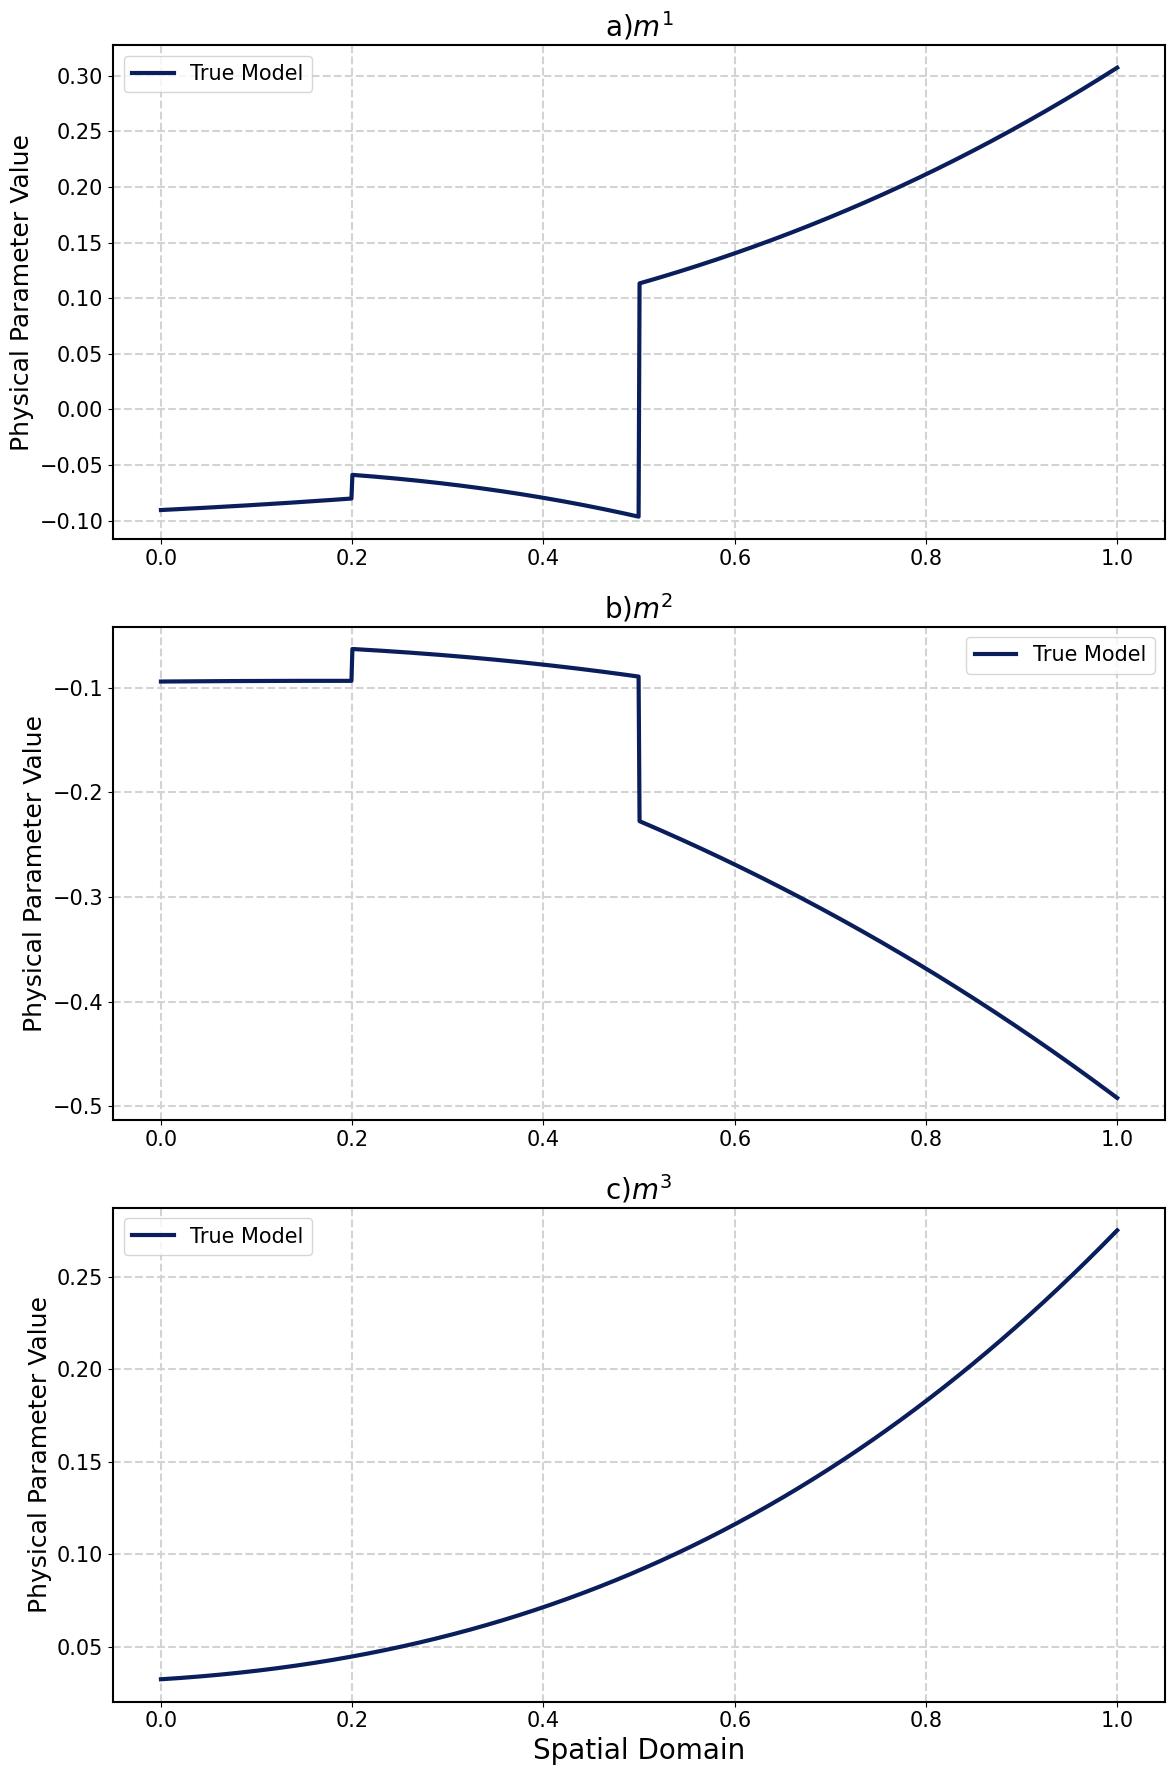

In [28]:
%matplotlib inline
#################################
# Create fake true model and data
#################################
# Edit region -------------
# Each row in the list of arguments is a tuple with the following structure:
# (seed, is it continuous?, locations of discontinuities)
# If you flag it as not continuous, and don't give the discontinuities, it will
# put them randomly
true_model = M.random_member(args_list=[(10, False, [0.2, 0.5]),
                                        (2, False, [0.2, 0.5]),
                                        (3, True)])
# Edit region -------------

# We generate the data
data = G.map(true_model)

# And now we plot
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
labels = ['a)', 'b)', 'c)']
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(domain.mesh, submodel.evaluate(domain.mesh),
            label='True Model', color=colors[99], linewidth=3)
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_ylabel('Physical Parameter Value', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].legend(fontsize=15)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
axes[-1].set_xlabel('Spatial Domain', fontsize=20)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('norm_bound_effect_images/truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

We create not one, but three different upper bound functions for the true model. Bound 1 is the most conservative, and bound 3 is the tightest.

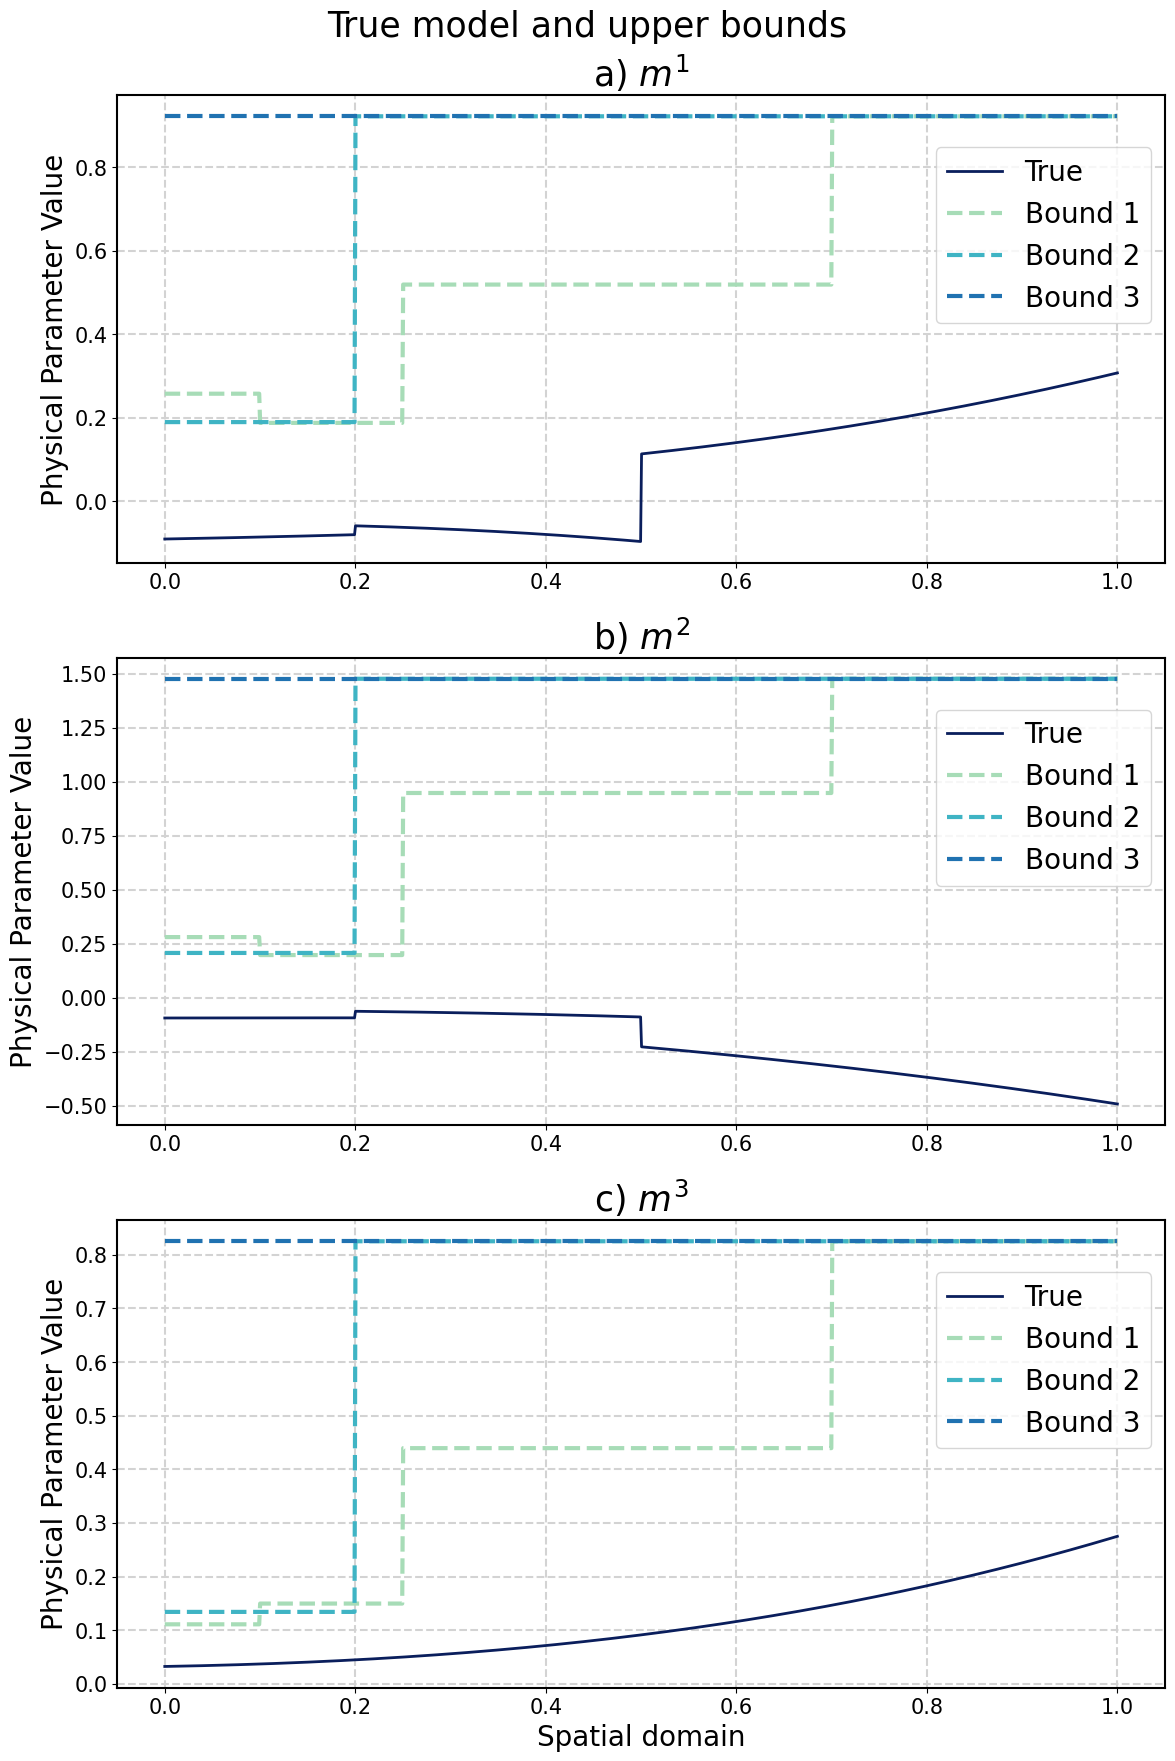

In [29]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = [np.array([0,0.1, 0.25, 0.7, domain.bounds[0][1]]),
            np.array([0, 0.2, domain.bounds[0][1]]),
            np.array([0, domain.bounds[0][1]])]
# Edit region -------------

upper_bounds = {}
for model, param in zip(true_model, physical_parameters):
    upper_bounds[param] = []
    for interval in intervals:
        values = np.abs(model.evaluate(interval[1:]))*3
        upper_bound = functions.Piecewise_1D(domain=model.domain,
                                intervals=interval,
                                values=values)
        upper_bounds[param].append(upper_bound)

norm_bounds = []
for bound_tuple in zip(*upper_bounds.values()):
    norm_bounds.append(M.norm(bound_tuple))

# Plotting
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
labels = ['a) ', 'b) ', 'c) ']

for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(domain.mesh, submodel.evaluate(domain.mesh),
            label='True', color=colors[99], linewidth=2)
    # Set title and labels
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=25)
    axes[i].set_ylabel('Physical Parameter Value', fontsize=20)
    # Set tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
for bound_no, bound_tuple in enumerate(zip(*upper_bounds.values())):
    for i, bound in enumerate(bound_tuple):
        axes[i].plot(domain.mesh, bound.evaluate(domain.mesh),
                label='Bound ' + str(bound_no + 1), color=colors[30 + bound_no*20],
                linestyle='--', linewidth=3)
        axes[i].legend(fontsize=20, loc='center right', bbox_to_anchor=(1, 0.7))
plt.suptitle('True model and upper bounds', fontsize=25)
plt.xlabel('Spatial domain', fontsize=20)
plt.tight_layout()
plt.savefig('norm_bound_effect_images/bounds.pdf', bbox_inches='tight')
plt.show()

In [30]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bounds[0], data=data)

In [31]:
problem.solve()

In [32]:
# Compute True property
true_property = T.map(true_model)

With the problem solved, we will find the solution (property bounds) in "problem.solution" and we can plot it.

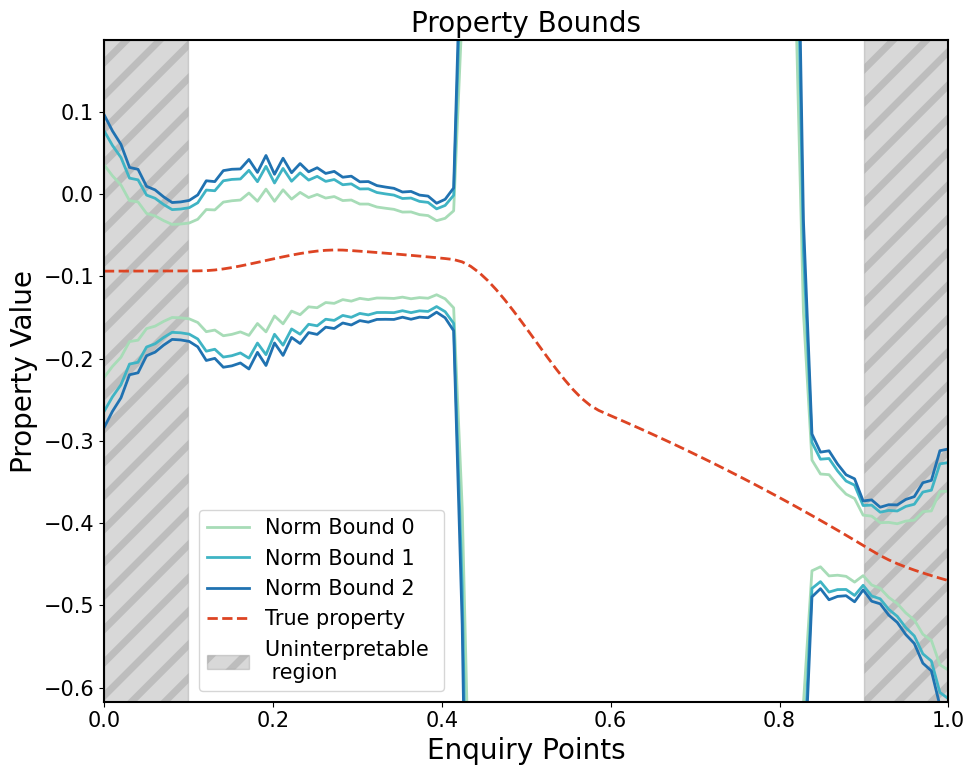

In [34]:
###############
# Plot solution
###############
matplotlib.rcParams['hatch.linewidth'] = 5.0
# Find limits for y axis
y_max = np.mean(true_property) + (np.max(true_property) - np.min(true_property))
y_min = np.mean(true_property) - (np.max(true_property) - np.min(true_property))
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
plt.title('Property Bounds', fontsize=20)  # Increase font size and add bold
for index, upper_bound in enumerate(norm_bounds):
    problem.change_bound(upper_bound)
    problem.solve()
    plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[30 + index*20],
            linewidth=2, label='Norm Bound ' + str(index + 1))  # Increase line width
    plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[30 + index*20],
            linewidth=2)  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423', linestyle='--',
         linewidth=2, label='True property')
plt.fill_betweenx([y_min, y_max], 0, width/2, color='gray', hatch='/',
                  alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - width/2, domain.bounds[0][1],
                  color='gray', hatch='/', alpha=0.3)
plt.ylim([y_min, y_max])
plt.xlim([0,1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='lower left', bbox_to_anchor=(0.1, 0))

plt.xlabel('Enquiry Points', fontsize=20)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=20)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('norm_bound_effect_images/norm_bound_effect.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()